<a href="https://colab.research.google.com/github/alexgaarciia/SyntheticTrafficRouting/blob/main/statistical_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# If in Google Colab, clone the repository
if IN_COLAB:
    !git clone https://github.com/alexgaarciia/SyntheticTrafficRouting.git
    import os
    os.chdir('SyntheticTrafficRouting/')
    print("Repository cloned!")
else:
    print("Not in Google Colab, skipping repository clone.")

Not in Google Colab, skipping repository clone.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from functions import rescale_demand

# Load real and synthetic data

In [3]:
combined_data = pd.read_csv("real_data.csv", sep=",")
synthetic_data_sdv = pd.read_csv("synthetic_data_sdv.csv", sep=",")
synthetic_data_gan = pd.read_csv("synthetic_data_gan.csv", sep=",")

In [4]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(combined_data)

# Measure the statistical similarity between real and synthetic data

## SDV Generated Data

In [5]:
quality_report = evaluate_quality(
    combined_data,
    synthetic_data_sdv,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 105.94it/s]|
Column Shapes Score: 92.43%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 93.04it/s]|
Column Pair Trends Score: 71.4%

Overall Score (Average): 81.91%



In [6]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='source',
    metadata=metadata
)

fig.show()

In [7]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='target',
    metadata=metadata
)

fig.show()

## GAN Generated Data

In [8]:
quality_report2 = evaluate_quality(
    combined_data,
    synthetic_data_gan,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 181.74it/s]|
Column Shapes Score: 89.22%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 59.70it/s]|
Column Pair Trends Score: 81.1%

Overall Score (Average): 85.16%



In [9]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='source',
    metadata=metadata
)

fig.show()

In [10]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='target',
    metadata=metadata
)

fig.show()

# Link load comparison

To further extent the comparison between the real data and the synthetic data, we want to see how much does the link load (demand_value) varies between these two.

To do so, we will follow this approach:
1. For each dataset (real and synthetic), we will create a new dataset that stores, for each unique source-destination pair, the total link load. This is computed by summing up the demand value for each unique pair.
2. Calculate the absolute and relative difference in link loads.

$$
AD = |y - \hat{y}|
$$

$$
RD = \left| \frac{y - \hat{y}}{y} \right|
$$

In [4]:
growth_factor = (1 + 0.45) ** (2025 - 2004)

combined_data = rescale_demand(combined_data, growth_factor)
synthetic_data_sdv = rescale_demand(synthetic_data_sdv, growth_factor)
synthetic_data_gan = rescale_demand(synthetic_data_gan, growth_factor)

In [5]:
# Group by source and target
real_clean = combined_data.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_gan_clean = synthetic_data_gan.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_sdv_clean = synthetic_data_sdv.groupby(["source", "target"])["demand_value"].sum().reset_index()

In [6]:
# Filter out rows with same source and destination
synthetic_gan_clean = synthetic_gan_clean[synthetic_gan_clean["source"] != synthetic_gan_clean["target"]]
synthetic_sdv_clean = synthetic_sdv_clean[synthetic_sdv_clean["source"] != synthetic_sdv_clean["target"]]

In [7]:
# Merge datasets
df_comparison_temp = pd.merge(real_clean, synthetic_gan_clean,
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_real", "_gan")).fillna(0)

df_comparison = pd.merge(df_comparison_temp, synthetic_sdv_clean,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_comparison.rename(columns={"demand_value": "demand_value_sdv"}, inplace=True)

In [8]:
# Calculate the absolute and relative differences
df_comparison["abs_diff_gan"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_gan"])
df_comparison["rel_diff_gan"] = df_comparison["abs_diff_gan"] / df_comparison["demand_value_real"]

df_comparison["abs_diff_sdv"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_sdv"])
df_comparison["rel_diff_sdv"] = df_comparison["abs_diff_sdv"] / df_comparison["demand_value_real"]

In [9]:
df_comparison

source  target  demand_value_real  demand_value_gan  demand_value_sdv  \
0    ATLAM5  ATLAng       4.291655e+04      2.545895e+03      2.375574e+05   
1    ATLAM5  CHINng       1.854549e+05      4.056228e+04      3.504306e+06   
2    ATLAM5  DNVRng       2.357684e+04      3.768816e+04      6.018870e+05   
3    ATLAM5  HSTNng       8.904062e+04      5.546799e+05      4.249619e+05   
4    ATLAM5  IPLSng       1.011742e+05      3.999567e+05      3.424133e+05   
..      ...     ...                ...               ...               ...   
127  WASHng  KSCYng       6.400367e+06      3.624949e+07      1.477076e+07   
128  WASHng  LOSAng       2.938775e+07      6.761763e+07      1.166709e+07   
129  WASHng  NYCMng       5.014566e+07      4.232845e+07      1.425129e+07   
130  WASHng  SNVAng       9.639292e+05      1.474551e+07      3.598038e+06   
131  WASHng  STTLng       1.108233e+07      1.372562e+07      8.237910e+06   

     abs_diff_gan  rel_diff_gan  abs_diff_sdv  rel_diff_sdv  
0    4.037065e+04      0.940678  1.946409e+05      4.535334  
1    1.448926e+05      0.781282  3.318852e+06     17.895731  
2    1.411132e+04      0.598524  5.783102e+05     24.528738  
3    4.656393e+05      5.229516  3.359212e+05      3.772674  
4    2.987824e+05      2.953148  2.412391e+05      2.384393  
..            ...           ...           ...           ...  
127  2.984913e+07      4.663659  8.370389e+06      1.307798  
128  3.822988e+07      1.300878  1.772067e+07      0.602995  
129  7.817215e+06      0.155890  3.589437e+07      0.715802  
130  1.378158e+07     14.297300  2.634109e+06      2.732679  
131  2.643296e+06      0.238515  2.844416e+06      0.256662  

[132 rows x 9 columns]

In [10]:
mad_gan = df_comparison['abs_diff_gan'].mean()
mrd_gan = df_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_sdv = df_comparison['abs_diff_sdv'].mean()
mrd_sdv = df_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_sdv}")
print(f"Mean Relative Difference (SDV): {mrd_sdv}")

Mean Absolute Difference (GAN): 8063934.389271309
Mean Relative Difference (GAN): 5.769206010721678

Mean Absolute Difference (SDV): 4620748.953320343
Mean Relative Difference (SDV): 2.393097584057493


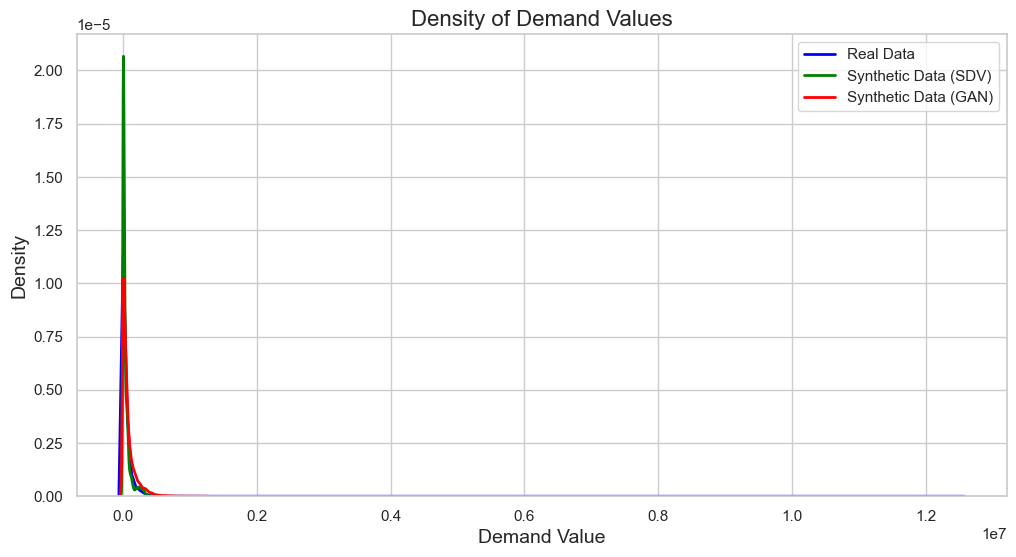

In [13]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis object
plt.figure(figsize=(12, 6))

# Plot the density for 'demand_value' from real and synthetic data
sns.kdeplot(combined_data['demand_value'], color='blue', label='Real Data', linewidth=2)
sns.kdeplot(synthetic_data_sdv['demand_value'], color='green', label='Synthetic Data (SDV)', linewidth=2)
sns.kdeplot(synthetic_data_gan['demand_value'], color='red', label='Synthetic Data (GAN)', linewidth=2)

# Add labels and title
plt.title('Density of Demand Values', fontsize=16)
plt.xlabel('Demand Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()

# Lowest link load comparison

In [14]:
# Group by 'source' and 'target', then get the minimum 'demand_value' for each group
min_demand_real = combined_data.loc[combined_data.groupby(['source', 'target'])['demand_value'].idxmin()]
min_demand_gan = synthetic_data_gan.loc[synthetic_data_gan.groupby(['source', 'target'])['demand_value'].idxmin()]
min_demand_sdv = synthetic_data_sdv.loc[synthetic_data_sdv.groupby(['source', 'target'])['demand_value'].idxmin()]

In [15]:
# Filter out rows with same source and destination
min_demand_gan = min_demand_gan[min_demand_gan["source"] != min_demand_gan["target"]]
min_demand_sdv = min_demand_sdv[min_demand_sdv["source"] != min_demand_sdv["target"]]

In [16]:
# Merge datasets
df_min_comparison_temp = pd.merge(min_demand_real, min_demand_gan,
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_min_real", "_min_gan")).fillna(0)

df_min_comparison = pd.merge(df_min_comparison_temp, min_demand_sdv,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_min_comparison.rename(columns={"demand_value": "demand_value_min_sdv"}, inplace=True)

In [17]:
# Calculate the absolute and relative differences
df_min_comparison["abs_diff_gan"] = abs(
    df_min_comparison["demand_value_min_real"] - df_min_comparison["demand_value_min_gan"])
df_min_comparison["rel_diff_gan"] = df_min_comparison["abs_diff_gan"] / df_min_comparison["demand_value_min_real"]

df_min_comparison["abs_diff_sdv"] = abs(
    df_min_comparison["demand_value_min_real"] - df_min_comparison["demand_value_min_sdv"])
df_min_comparison["rel_diff_sdv"] = df_min_comparison["abs_diff_sdv"] / df_min_comparison["demand_value_min_real"]

In [18]:
df_min_comparison

source  target  demand_value_min_real  demand_value_min_gan  \
0    ATLAM5  ATLAng              65.268286             32.680143   
1    ATLAM5  CHINng              65.268286             32.673379   
2    ATLAM5  DNVRng              65.268286             34.179528   
3    ATLAM5  HSTNng              65.268286             33.368505   
4    ATLAM5  IPLSng              65.268286             32.927175   
..      ...     ...                    ...                   ...   
127  WASHng  KSCYng             117.168162          33443.989116   
128  WASHng  LOSAng              65.268286            397.161549   
129  WASHng  NYCMng            3404.455671            879.095106   
130  WASHng  SNVAng              65.268286           1084.497529   
131  WASHng  STTLng             280.604434           4998.529920   

     demand_value_min_sdv  abs_diff_gan  rel_diff_gan  abs_diff_sdv  \
0               32.632919     32.588143      0.499295     32.635367   
1               32.632919     32.594907      0.499399     32.635367   
2               32.632919     31.088758      0.476323     32.635367   
3               32.632919     31.899781      0.488749     32.635367   
4               32.632919     32.341111      0.495510     32.635367   
..                    ...           ...           ...           ...   
127             32.632919  33326.820954    284.435808     84.535243   
128            190.520640    331.893263      5.085062    125.252354   
129           3046.969420   2525.360565      0.741781    357.486251   
130             32.632919   1019.229243     15.615995     32.635367   
131             32.632919   4717.925485     16.813439    247.971515   

     rel_diff_sdv  
0        0.500019  
1        0.500019  
2        0.500019  
3        0.500019  
4        0.500019  
..            ...  
127      0.721486  
128      1.919039  
129      0.105005  
130      0.500019  
131      0.883705  

[132 rows x 9 columns]

In [19]:
mad_gan = df_min_comparison['abs_diff_gan'].mean()
mrd_gan = df_min_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_sdv = df_min_comparison['abs_diff_sdv'].mean()
mrd_sdv = df_min_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_sdv}")
print(f"Mean Relative Difference (SDV): {mrd_sdv}")

Mean Absolute Difference (GAN): 8220.365288668228
Mean Relative Difference (GAN): 35.30473323518556

Mean Absolute Difference (SDV): 3698.797721092186
Mean Relative Difference (SDV): 3.0841688025916345


# Mean, Median, STD Comparison

In [20]:
combined_data.describe(), synthetic_data_gan.describe(), synthetic_data_sdv.describe()

(       demand_value
 count  2.051400e+04
 mean   4.442444e+04
 std    1.492940e+05
 min    3.263292e+01
 25%    3.636665e+03
 50%    1.737276e+04
 75%    5.221912e+04
 max    1.251354e+07,
        demand_value
 count  2.051400e+04
 mean   7.768213e+04
 std    1.039194e+05
 min    3.263294e+01
 25%    9.210180e+03
 50%    4.066613e+04
 75%    1.004200e+05
 max    1.235073e+06,
         demand_value
 count   20514.000000
 mean    41924.101660
 std     64134.013858
 min        32.632919
 25%      4916.363563
 50%     17770.183598
 75%     51445.367626
 max    413755.416471)